<a href="https://colab.research.google.com/github/michhottinger/CS-Data-Science-Build-Week-1/blob/master/cs_build_week_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
# Import the data
df = pd.read_csv('https://raw.githubusercontent.com/michhottinger/CS-Data-Science-Build-Week-1/master/datasets_33180_43520_heart.csv')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
#dealing with categorical data. One hot encoding would work here too

a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")
d = pd.get_dummies(df['sex'], prefix = "sex")
e = pd.get_dummies(df['restecg'], prefix = "restecg")

frames = [df, a, b, c, d, e]
df = pd.concat(frames, axis = 1)
df.head()


df_copy = df.drop(columns = ['cp', 'thal', 'slope', 'sex', 'restecg'])
df_copy.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2,sex_0,sex_1,restecg_0,restecg_1,restecg_2
0,63,145,233,1,150,0,2.3,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,37,130,250,0,187,0,3.5,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0
2,41,130,204,0,172,0,1.4,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0
3,56,120,236,0,178,0,0.8,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0
4,57,120,354,0,163,1,0.6,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0


In [4]:
df_copy.shape

(303, 25)

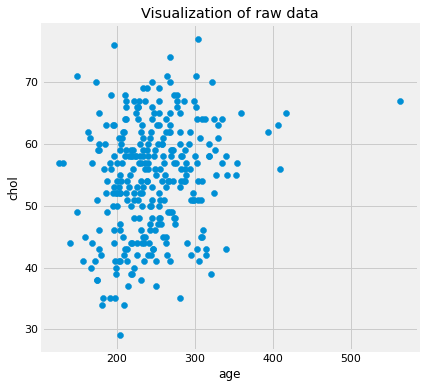

In [5]:
# Plot the data to see what some of the features look like
#could also use crosstabs here
plt.figure(figsize=(6, 6))
plt.scatter(df_copy.chol, df_copy.age)
plt.xlabel('age')
plt.ylabel('chol')
plt.title('Visualization of raw data');

In [6]:
#make a copy called data to use clusters on just a few features
data = df_copy[['chol', 'age']]
data.shape

(303, 2)

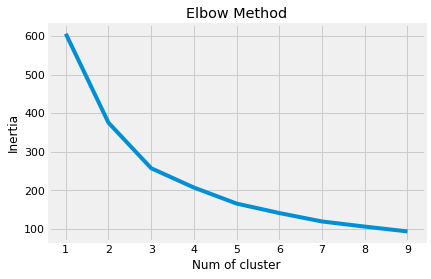

In [7]:
#uses sklearn kMeans
# Standardize the the small data set
X_std = StandardScaler().fit_transform(data)

#use elbow graph to see how many clusters might work
elbow = []
for i in range(1,10):
    km = KMeans(n_clusters = i, max_iter = 20, random_state = 42)
    km.fit(X_std)
    elbow.append(km.inertia_)

#Plot cluster
plt.plot(range(1,10), elbow)
plt.xlabel('Num of cluster')
plt.title('Elbow Method')
plt.ylabel('Inertia')
plt.show()

In [8]:
# Run sklearn KMeans: on samll data set here

km = KMeans(n_clusters=3, max_iter=500, random_state = 42)
km.fit(X_std)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [9]:
centroids = km.cluster_centers_
centroids


array([[ 1.12796899,  0.57406348],
       [-0.30406765, -1.15211421],
       [-0.54069438,  0.56294192]])

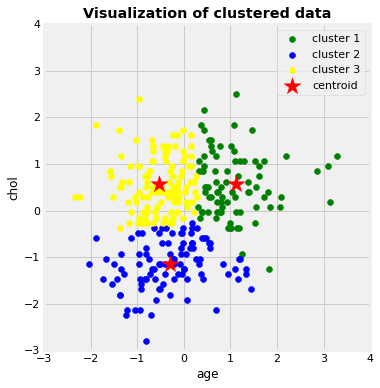

In [10]:
# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1],
            c='yellow', label='cluster 3')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-3, 4])
plt.ylim([-3, 4])
plt.xlabel('age')
plt.ylabel('chol')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

In [11]:
data['cluster'] = km.labels_
data.head(5)
data.describe()

,chol,age,cluster
count,303.000000,303.000000,303.000000
mean,246.264026,54.366337,1.115512
std,51.830751,9.082101,0.811664
min,126.000000,29.000000,0.000000
25%,211.000000,47.500000,0.000000
50%,240.000000,55.000000,1.000000
75%,274.500000,61.000000,2.000000
max,564.000000,77.000000,2.000000


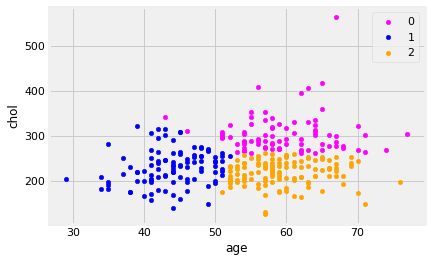

In [12]:
fig, ax = plt.subplots()
colors = {0:'magenta', 1:'blue', 2:'orange', 3:'red', 4:'pink', 5:'yellow', 6:'purple', 7:'black', 8:'green'}
grouped = data.groupby('cluster')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='age', y='chol', label=key, color=colors[key])
plt.show()

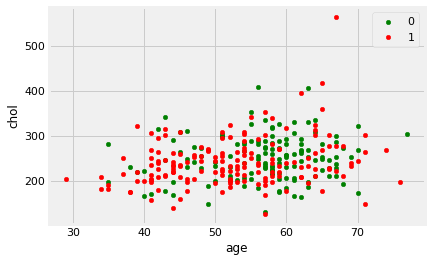

In [13]:
# diagnosis of heart disease (angiographic disease status)
# -- Value 0: < 50% diameter narrowing -- Value 1: > 50% diameter narrowing

#check out the same data on the whole dataset that we have preped showing the target

fig, ax = plt.subplots()
colors = {0:'green', 1:'red'}
groups = df_copy.groupby('target')
for key, item in groups:
    item.plot(ax=ax, kind='scatter', x='age', y='chol', label=key, color=colors[key])
plt.show()

In [14]:

features = ['age',	'trestbps',	'chol', 
            'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 
            'cp_1', 'cp_2', 'cp_3', 'thal_0', 'thal_1', 'thal_2', 
            'thal_3', 'slope_0',	'slope_1', 'slope_2', 'sex_0', 'sex_1', 'restecg_0', 
            'restecg_1', 'restecg_2']
df_copy.shape

(303, 25)

In [15]:
X = df_copy
X = df_copy.drop(columns = ['target', 'fbs'])

X.shape


(303, 23)

In [41]:
#standardize X
X_std4 = StandardScaler().fit_transform(X)
X_std4

array([[ 0.9521966 ,  0.76395577, -0.25633371, ..., -0.11566299,
         0.07687676, -1.07788328],
       [-1.91531289, -0.09273778,  0.07219949, ..., -0.11566299,
        -1.21721536,  0.15923276],
       [-1.47415758, -0.09273778, -0.81677269, ..., -0.11566299,
         1.37096887,  1.3963488 ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ..., -0.11566299,
         0.07687676, -1.07788328],
       [ 0.29046364, -0.09273778, -2.2275329 , ..., -0.11566299,
         0.07687676, -1.07788328],
       [ 0.29046364, -0.09273778, -0.19835726, ..., -0.11566299,
         1.37096887,  1.3963488 ]])

In [55]:
#pca data to deal with categorical stuff using X_std4 already scaled
from sklearn.decomposition import PCA
std_pca = StandardScaler().fit_transform(X)

Z = std_pca

# Perform PCA
pca = PCA(17)
pca.fit(Z)
transformed_data = pca.transform(Z)
transformed_data


array([[ 2.15906033, -0.29088097,  2.61572135, ..., -1.376803  ,
        -0.37948679, -0.58184331],
       [-2.15334085, -1.1308321 , -0.34544697, ...,  1.7843542 ,
        -0.29878423,  0.15707322],
       [-2.36599359,  1.71188766,  1.12857401, ..., -0.171887  ,
         1.03811528,  1.17126678],
       ...,
       [ 3.13232401, -1.18083334, -1.51721785, ...,  0.57936298,
        -1.1884962 ,  1.40028247],
       [ 2.94734399, -1.79236886, -2.16484724, ..., -0.62375573,
         0.37225247, -0.201015  ],
       [-1.05304896,  2.56346877,  0.76867927, ...,  0.3948038 ,
         0.03080351, -0.40363372]])

In [29]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

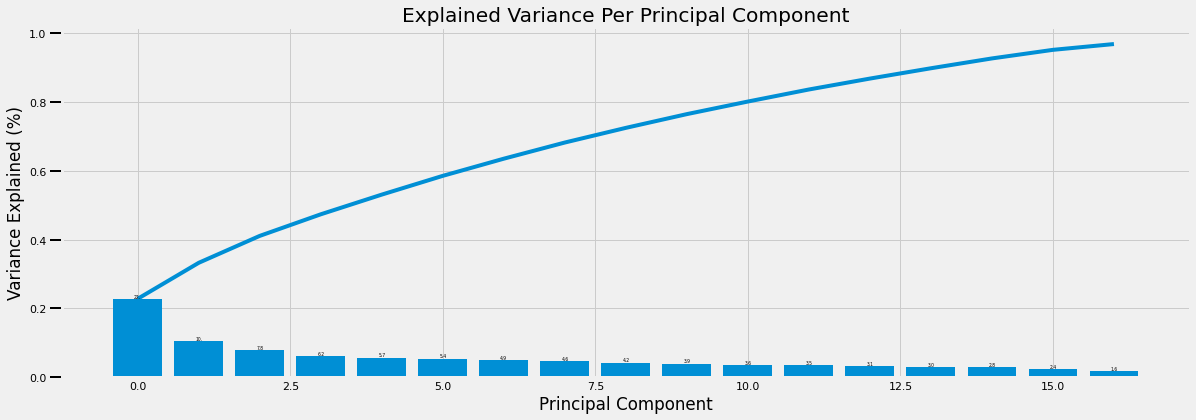

In [56]:
scree_plot(pca)#find where the variance is highest

In [57]:
# K-Means on PCA data
kmeanspca = KMeans(n_clusters=3, max_iter=1000, n_init=500, random_state=42)
kmeanspca.fit(transformed_data)
print(kmeanspca.labels_)
centroidspca = kmeanspca.cluster_centers_
centroidspca

[1 2 0 2 0 1 0 2 2 2 2 0 2 1 0 0 0 0 2 0 1 2 2 1 2 0 2 2 0 2 0 2 2 2 2 0 0
 2 0 0 0 2 1 0 2 2 2 2 0 0 0 1 1 0 0 2 2 2 2 0 0 2 1 2 2 0 2 0 2 0 1 2 2 2
 0 0 2 2 2 1 2 2 0 1 0 0 2 2 0 0 2 2 2 0 0 1 0 2 2 2 2 1 0 2 2 0 1 0 0 0 0
 2 0 2 2 0 2 1 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 2 1 1 0 2 0 0 0 2 0 0
 2 2 1 0 1 0 0 0 2 2 1 2 2 0 2 2 2 1 1 0 1 1 1 2 2 2 1 1 1 2 1 1 1 1 0 1 1
 2 1 1 2 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 2 1 0 1 1 1 1 1 1 2 1 1 1 0 1 2 1 1 1 0
 1 1 2 1 0 1 2 1 2 1 1 2 1 1 2 1 2 1 2 0 1 1 1 1 2 1 1 2 2 1 1 2 1 1 1 1 1
 0 1 1 1 1 1 0]


array([[-1.20902606e+00,  2.10128511e+00, -5.35464016e-01,
        -1.74647157e-01,  5.81831451e-02,  4.96074584e-02,
        -1.16977765e-02, -2.02455525e-01,  1.49604560e-01,
        -3.95564579e-02, -1.78393886e-01, -1.05313894e-01,
         1.86311996e-01,  4.88943562e-02, -1.93498142e-01,
         1.06748123e-02, -3.23792153e-02],
       [ 2.64202437e+00, -3.24842038e-01,  3.42099430e-02,
         1.21836026e-01, -1.44594374e-01, -3.34171219e-02,
        -1.23161515e-01,  3.00477026e-02,  2.98890613e-02,
         2.67506452e-02,  1.19831781e-02, -2.13369870e-02,
        -1.68851827e-02,  5.98928180e-02, -1.44601242e-02,
         1.26869133e-01,  9.98585191e-02],
       [-2.20544812e+00, -1.32999493e+00,  3.97686462e-01,
        -4.21092312e-03,  1.27249014e-01, -2.43398378e-04,
         1.58617610e-01,  1.29655810e-01, -1.58841504e-01,
         6.80147272e-05,  1.31783341e-01,  1.12175147e-01,
        -1.32344766e-01, -1.12563682e-01,  1.76165227e-01,
        -1.62264997e-01, -9.4

In [58]:
#PCA's datatable with pca clusters
X_copy = X
X_copy['cluster_pca'] = kmeanspca.labels_
X_copy

,age,trestbps,chol,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2,sex_0,sex_1,restecg_0,restecg_1,restecg_2,cluster_pca,clusters
0,63,145,233,150,0,2.3,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0
1,37,130,250,187,0,3.5,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,2,2
2,41,130,204,172,0,1.4,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1
3,56,120,236,178,0,0.8,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,2,2
4,57,120,354,163,1,0.6,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,1,0.2,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0
299,45,110,264,132,0,1.2,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0
300,68,144,193,141,0,3.4,2,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
301,57,130,131,115,1,1.2,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0


In [46]:

# Applying k-means to the dataset without PCA
kmeans4 = KMeans(n_clusters=3, max_iter=1000, n_init=500, random_state=42) 
y_kmeans4 = kmeans4.fit_predict(X_std4)

centroids4 = kmeans4.cluster_centers_
centroids4

#kmeans.labels_ are the same thing as y_means


array([[ 0.3624704 ,  0.20793097,  0.05830431, -0.63147956,  0.60730552,
         0.65599028,  0.39460433,  0.5445667 , -0.37776087, -0.36064053,
         0.11905004,  0.0205469 ,  0.34304481, -0.76865974,  0.61580321,
         0.11759654,  0.69775543, -0.75696524, -0.43231168,  0.43231168,
         0.2694913 , -0.29255812,  0.10156357,  0.07687676, -1.07788328],
       [ 0.1062006 , -0.11432925,  0.22656767,  0.1487675 , -0.3846142 ,
        -0.37293198, -0.32023539, -0.33466544,  0.14681132,  0.30878362,
        -0.10242432,  0.06908801, -0.25131234,  0.81044998, -0.71797045,
        -0.12883756, -0.11955931,  0.18502161,  1.46841752, -1.46841752,
        -0.11668998,  0.11865154, -0.00881578,  1.37096887,  1.3963488 ],
       [-0.52567367, -0.15784649, -0.25633371,  0.64210092, -0.41945603,
        -0.48794402, -0.21487822, -0.38450004,  0.33670537,  0.18317247,
        -0.0600626 , -0.08151391, -0.2090081 ,  0.2655093 , -0.15638612,
        -0.03664502, -0.74624543,  0.76421022, -0

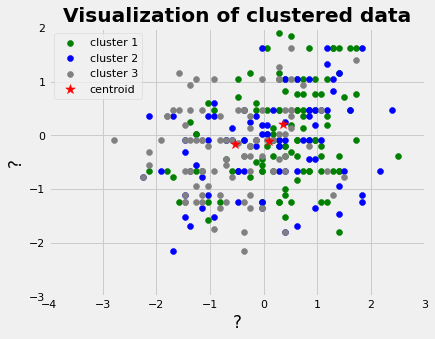

In [47]:
# Visualising the clusters
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std4[y_kmeans4 == 0, 0], X_std4[y_kmeans4 == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std4[y_kmeans4 == 1, 0], X_std4[y_kmeans4 == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(X_std4[y_kmeans4 == 2, 0], X_std4[y_kmeans4 == 2, 1],
            c='grey', label='cluster 3')
# plt.scatter(X_std4[kmeans4.labels_ == 3, 0], X_std4[kmeans4.labels_ == 3, 1],
#             c='magenta', label='cluster 4')
plt.scatter(centroids4[:, 0], centroids4[:, 1], marker='*', s=100,
            c='red', label='centroid')
plt.legend()
plt.xlim([-4, 3])
plt.ylim([-3, 2])
plt.xlabel('?')
plt.ylabel('?')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

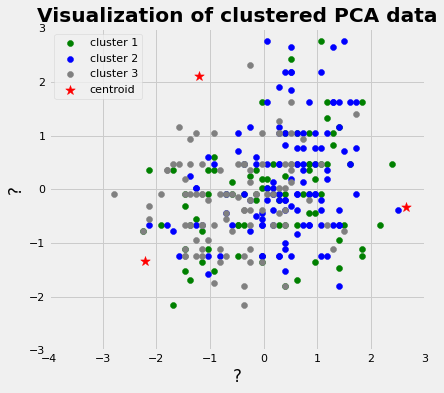

In [59]:
# Visualising the clusters with PCA 15
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(std_pca[kmeanspca.labels_ == 0, 0], std_pca[kmeanspca.labels_ == 0, 1],
            c='green', label='cluster 1')
plt.scatter(std_pca[kmeanspca.labels_ == 1, 0], std_pca[kmeanspca.labels_ == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(std_pca[kmeanspca.labels_ == 2, 0], std_pca[kmeanspca.labels_ == 2, 1],
            c='grey', label='cluster 3')
# plt.scatter(std_pca[kmeanspca.labels_ == 3, 0], std_pca[kmeanspca.labels_ == 3, 1],
#             c='magenta', label='cluster 4')
plt.scatter(centroidspca[:, 0], centroidspca[:, 1], marker='*', s=100,
            c='red', label='centroid')
plt.legend()
plt.xlim([-4, 3])
plt.ylim([-3, 3])
plt.xlabel('?')
plt.ylabel('?')
plt.title('Visualization of clustered PCA data', fontweight='bold')
ax.set_aspect('equal');

The results using all the features is a mess--the clusters appear to not create groups.


In [50]:
X['clusters'] = pd.DataFrame(kmeans4.labels_).values
X.head()

,age,trestbps,chol,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2,sex_0,sex_1,restecg_0,restecg_1,restecg_2,cluster_pca,clusters
0,63,145,233,150,0,2.3,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0
1,37,130,250,187,0,3.5,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,2,2
2,41,130,204,172,0,1.4,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,1
3,56,120,236,178,0,0.8,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,2,2
4,57,120,354,163,1,0.6,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1


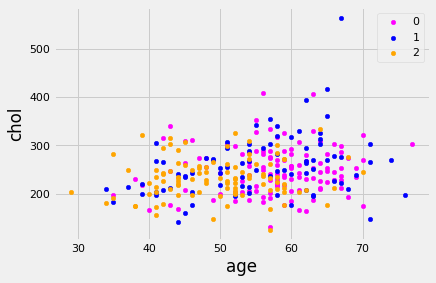

In [51]:
#data with cluster lables-- non-pca
fig, ax = plt.subplots()
colors = {0:'magenta', 1:'blue', 2:'orange', 3:'red', 4:'pink', 5:'yellow', 6:'purple', 7:'black', 8:'green'}
grouped = X.groupby('clusters')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='age', y='chol', label=key, color=colors[key])
plt.show()

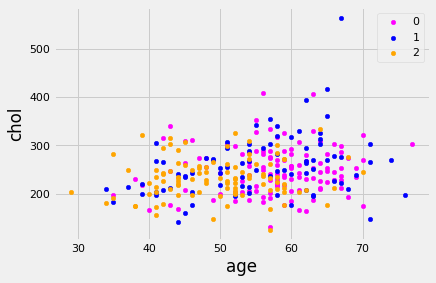

In [52]:
#pca data with cluster labels


fig, ax = plt.subplots()
colors = {0:'magenta', 1:'blue', 2:'orange', 3:'red', 4:'pink', 5:'yellow', 6:'purple', 7:'black', 8:'green'}
grouped = X_copy.groupby('cluster_pca')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='age', y='chol', label=key, color=colors[key])
plt.show()

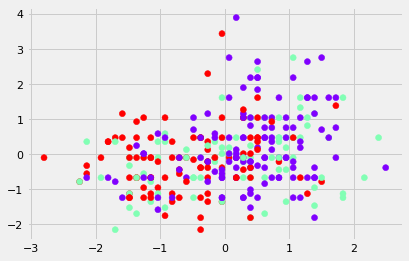

In [53]:
plt.scatter(X_std4[:, 0], X_std4[:, 1], c=kmeans4.labels_, cmap='rainbow')

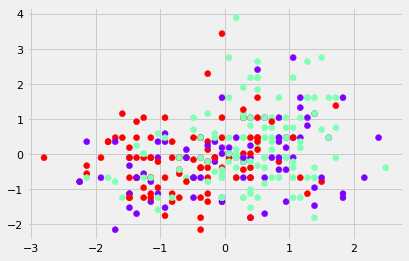

In [60]:
plt.scatter(std_pca[:, 0], std_pca[:, 1], c=kmeanspca.labels_, cmap='rainbow')